            speed       power
count  451.000000  451.000000
mean    13.004302   53.231246
std      6.835979   40.522055
min      0.325000    0.067000
25%      7.344500    8.543500
50%     13.038000   58.168000
75%     18.781500   94.725500
max     24.399000  113.556000


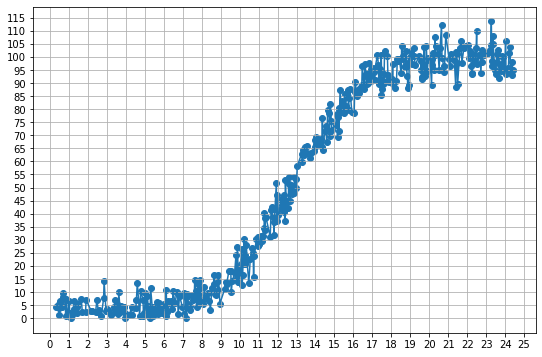

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

%matplotlib inline

source_df = pd.read_csv("Source_data/Source_file.csv")
cleansed_df = source_df.loc[~(source_df["power"] == 0) & (source_df["speed"] != 0)]

print(cleansed_df.describe())

plt.figure(figsize = (9, 6))                                  # Set the plot size
plt.plot(cleansed_df["speed"], cleansed_df["power"])          
plt.scatter(x = cleansed_df["speed"], y = cleansed_df["power"])
plt.xticks(np.arange(0, round(cleansed_df["speed"].max(), 0) + 2, step = 1)) # Force all the xticks to be visible
plt.yticks(np.arange(0, round(cleansed_df["power"].max(), 0) + 4, step = 5)) # Force all the xticks to be visible
plt.grid(which = "major", axis = "x")                           # Show the minor grid lines on the x axis
plt.grid(which = "major", axis = "y")                           # Show the minor grid lines on the y axis
plt.show()


In [24]:
sp_ar, po_ar = cleansed_df["speed"].values, cleansed_df["power"].values

print("Speed:", sp_ar[:10], "\nPower:", po_ar[:10], sep = "\n")

Speed:
[0.325 0.4   0.45  0.501 0.526 0.551 0.576 0.626 0.676 0.701]

Power:
[4.331 5.186 3.826 1.048 5.553 6.498 5.241 4.22  7.974 9.746]


In [25]:
sp_train_ar, sp_test_ar, po_train_ar, po_test_ar = train_test_split(sp_ar, po_ar, test_size = 0.30, random_state = 74904)

print("Training set: %d rows\nTest set: %d rows" %(sp_train_ar.size, sp_test_ar.size))
print(print("Train:", sp_train_ar[:10], "\nTest:", sp_test_ar[:10], sep = "\n"))


Training set: 315 rows
Test set: 136 rows
Train:
[16.041 12.563 18.769 16.942  5.03   7.382 22.823 12.262 23.498 18.519]

Test:
[ 7.608  4.905  7.633  3.078 12.187 18.844  4.73  20.12   6.356 13.338]
None


In [26]:
lin_model = LinearRegression(fit_intercept=False).fit(sp_train_ar.reshape(-1,1), po_train_ar)
print(lin_model)

LinearRegression(fit_intercept=False)


In [27]:
predictions = lin_model.predict(sp_test_ar.reshape(-1,1))
np.set_printoptions(suppress = True)
print("Predict labels:", np.round(predictions, 3)[:10])
print("Actual labels:", po_test_ar[:10])

Predict labels: [33.467 21.577 33.577 13.54  53.609 82.893 20.807 88.506 27.959 58.673]
Actual labels: [ 8.471  7.06  14.788  3.063 45.056 92.655  0.82  89.078  5.842 64.541]


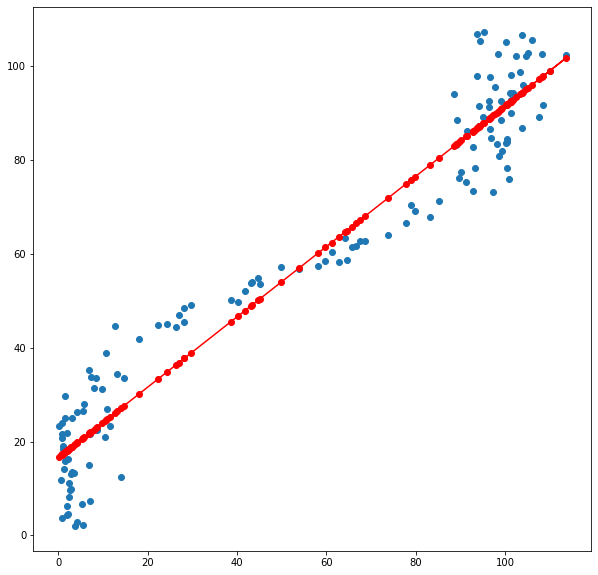

In [28]:
plt.figure(figsize = (10, 10))                                  # Set the plot size
plt.scatter(po_test_ar, predictions)
z = np.polyfit(po_test_ar, predictions, 1)
p = np.poly1d(z)
plt.plot(po_test_ar, p(po_test_ar), color = "r", marker = "o")
plt.show()

In [29]:
mse_lin = mean_squared_error(po_test_ar, predictions)
print("mse_lin:", mse_lin)

rsme_lin = np.sqrt(mse_lin)
print("rsme_lin:", rsme_lin)

r2_lin = r2_score(po_test_ar, predictions)
print("R2_lin:", r2_lin)                                                # R2 is low, suggesting model is not correct

mse_lin: 195.4204641444619
rsme_lin: 13.979286968385114
R2_lin: 0.8893161443654644


In [30]:
filename ="Models/lin_reg.pkl"
joblib.dump(lin_model, filename)

value = float(input("Input a value for the wind speed in m/s:"))

lin_model_load = joblib.load(filename)

speed_new = np.full(shape=1, fill_value=value, dtype="float64").reshape(-1, 1)

print()

if speed_new >= 0:
    
    result = lin_model_load.predict(speed_new)
    kmh = speed_new * 3.6
    MPH = speed_new * 2.23694
    
    if speed_new > 70:
        print("Warning:\nThis wind speed indicates that there is a category 5 hurricane blowing.\nThis faster than the highest recorded wind speed in Ireland.\n\n")
    
    elif speed_new > 58.05556:
        print("Warning:\nThis wind speed indicates that there is a category 4 hurricane blowing.\nThis faster than the highest recorded wind speed in Ireland.\n\n")

    elif speed_new > 50.55556:
        print("Warning:\nThis wind speed indicates that there is a category 3 hurricane blowing.\nThis faster than the highest recorded wind speed in Ireland.\n\n")
    
    elif speed_new > 49.44444:
        print("Warning:\nThis wind speed indicates that there is a category 3 hurricane blowing.\n\n")

    elif speed_new > 42.77778:
        print("Warning:\nThis wind speed indicates that there is a category 2 hurricane blowing.\n\n")
    
    elif speed_new > 33.05556:
        print("Warning:\nThis wind speed indicates that there is a category 1 hurricane blowing.\n\n")
    
    elif speed_new > 28.61111:
        print("Warning:\nThis wind speed indicates that there is a storm blowing.\n\n")
    
    print("Estimated power produced at wind speed of %.3f m/s (%.2f km/h, %.2f MPH) is %.3f kW/h." % (speed_new, kmh, MPH, result[0]))
              
else:
    print("Wind speed value cannot be negative.\nPlease select another wind speed value that is positive")
  

Input a value for the wind speed in m/s:7

Estimated power produced at wind speed of 7.000 m/s (25.20 km/h, 15.66 MPH) is 30.792 kW/h.
